## DATA CREATION 

### Importing Libraries

First, we will import the SVC class which will be used later to instantiate a support vector classifier.

In [1]:
from sklearn.svm import SVC

 Next, we will import the standard scaler class along with some other classes.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from fwTimeSeriesSplit import fwTimeSeriesSplit
import pandas as pd
import numpy as np
import talib as ta

Next, we import the pyplot class from matplotlib library. This will be used to plot the performance of the strategy later in the code.

In [3]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

### Importing Data

Use we will upload the data and save it in a Dataframe named as ‘Df’
To upload we use "pandas.read_csv("spy_800.csv")".
Our data is a 30 minute (half hour) OHLCV data for the SPY. 
Traded from 4AM to 7:30PM (practically round the clock)


In [4]:
#Df = pd.read_csv('SPY_800.csv') 
Df = pd.read_csv('NSE_cash.csv') 
Df=Df[['Time','Open','High','Low','Close','Volume']]

In [5]:
Df.head()

,Time,Open,High,Low,Close,Volume
0,09:15:59,319.25,319.40,316.05,317.70,143354
1,09:16:59,317.70,318.20,317.70,318.00,52695
2,09:17:59,318.00,318.85,318.00,318.55,47179
3,09:18:59,318.65,319.40,318.50,319.20,44745
4,09:19:59,319.30,319.85,319.20,319.65,57892


We will drop all rows which have no traded volume. This is done to avoid training on low liquidity moves. Alternatively, you can drop all those rows where volume is less than some value of your choice.


In [6]:
Df=Df.drop(Df[Df['Volume']==0].index)

Now, we will change the Time column to a ‘datetime’ type. This is done to so that we can check for the market closing time later in the code and square off any open positions before the market closes. .

In [7]:
Df['Time']=pd.to_datetime(Df['Time'])

In [8]:
Df.head()

,Time,Open,High,Low,Close,Volume
0,2020-02-21 09:15:59,319.25,319.40,316.05,317.70,143354
1,2020-02-21 09:16:59,317.70,318.20,317.70,318.00,52695
2,2020-02-21 09:17:59,318.00,318.85,318.00,318.55,47179
3,2020-02-21 09:18:59,318.65,319.40,318.50,319.20,44745
4,2020-02-21 09:19:59,319.30,319.85,319.20,319.65,57892


### Splitting Data

We will use 80% of our data to train and the rest 20% to test. To do this, we will create a split parameter which will divide the dataframe in an 80-20 ratio. This can be changed as per your choice, but it is advisable to give at least 70% data as train data for good results. "split" is the integer index value for the row corresponding to test-train split. 

In [9]:
t=.8
split = int(t*len(Df))

### Creating Indicators

Next, we decide the time period for which we will calculate our indicators. For this, we chose a variable ‘n’ with a value of 6 half hours. This is something you can change as per your choice. We will be creating all the indicators for the same time period. 


In [10]:
n=10 #this is the window for return periods (among other things)
#n=5

Next, we will create RSI and some other indicators. As you can see in the ‘RSI’ calculation below, two things are being done. First, the “Close” prices column is ‘shifted’ down by a single time interval, one minute, in our case. This is done so that we work on historical data. Secondly, “timeperiod” is chosen as “n” which we earlier defined as ‘6’ half hours. So if we are calculating RSI for ‘t’th half hour, we will use Closing prices of ‘t-10’, ‘t-9’, …’t-1’ half hours.) 


In [11]:
Df['RSI']=ta.RSI(np.array(Df['Close'].shift(1)), timeperiod=n)

In [12]:
Df['SMA'] = Df['Close'].shift(1).rolling(window=n).mean()
Df['Corr']=Df['Close'].shift(1).rolling(window=n).corr(Df['SMA'].shift(1))

SAR and ADX are calculated on High and Low prices because they are intended to be sensitive to new "Highs" and "Lows" created. In the SAR indicator the values of 0.2 represent the acceleration and maximum step parameters. These are just default values agreed upon by tradition. see:https://www.investopedia.com/terms/p/parabolicindicator.asp 

In [13]:
Df['SAR']=ta.SAR(np.array(Df['High'].shift(1)),np.array(Df['Low'].shift(1)),\
                  0.2,0.2)
Df['ADX']=ta.ADX(np.array(Df['High'].shift(1)),np.array(Df['Low'].shift(1)),\
                  np.array(Df['Open']), timeperiod =n)

We will pass yesterday's "High", "Low", and "Close" prices as input to the algorithm in variables named in lower cases. This will help the algorithm sense the volatility of the past time period.

In [14]:
Df['close'] = Df['Close'].shift(1)
Df['high'] = Df['High'].shift(1)
Df['low'] = Df['Low'].shift(1)

We will also pass two other values as features: the change in "Open" prices between yesterday and today & the difference between today's "Open" and yesterday's "Close" prices.

In [15]:
Df['OO']= Df['Open']-Df['Open'].shift(1)
Df['OC']= Df['Open']-Df['close']

Next, calculate the returns for every data point and save in "Ret". We also save returns of past 'n' half hours in 'n' columns named as 'return1', 'return2' and so on. This will help the algorithm to understand the trend of the returns in last 'n' periods.  

In [16]:
Df['Ret']=np.log(Df['Open'].shift(-1)/Df['Open'])
for i in range(1,n):
    Df['return%i'%i]=Df['Ret'].shift(i)

In [17]:
Df.head()

,Time,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,...,Ret,return1,return2,return3,return4,return5,return6,return7,return8,return9
0,2020-02-21 09:15:59,319.25,319.40,316.05,317.70,143354,NaN,NaN,NaN,NaN,...,-0.004867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-21 09:16:59,317.70,318.20,317.70,318.00,52695,NaN,NaN,NaN,NaN,...,0.000944,-0.004867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-21 09:17:59,318.00,318.85,318.00,318.55,47179,NaN,NaN,NaN,316.050,...,0.002042,0.000944,-0.004867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-21 09:18:59,318.65,319.40,318.50,319.20,44745,NaN,NaN,NaN,316.480,...,0.002038,0.002042,0.000944,-0.004867,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-21 09:19:59,319.30,319.85,319.20,319.65,57892,NaN,NaN,NaN,316.954,...,0.000939,0.002038,0.002042,0.000944,-0.004867,NaN,NaN,NaN,NaN,NaN


### Trimming the Data

We would like to keep the values of indicator ‘Corr’ between -1 and 1, as the correlation coefficient is always between these values. This is done by changing all values less than -1 to -1, and all values greater than 1 to 1. This doesn’t affect our calculations negatively because the extreme values are realised due to NAN values in the data, which need to be handled before training the algorithm. Then we drop all NANs from the entire dataframe.

In [18]:
#the correlation function used above to generate the Df['Corr'] column
#should not be generating any values outside -1 and 1; 
#however, something is going on that makes the function generate infinite or NAN values sometimes and
#we have to get rid of these errors

Df.loc[Df['Corr']<-1,'Corr']=-1
Df.loc[Df['Corr']>1,'Corr']=1
Df=Df.dropna()


### Creating Output Signal

Next, we assign signal values corresponding to ‘returns’ that were calculated earlier. To do this, we split the data into three 
equal parts, as per the returns. The highest returns’ quantile is assigned Signal ‘1’ or “Buy”.  Middle quantile is assigned Signal ‘0’ or ‘Do nothing’. Lowest quantile is assigned Signal ‘-1’ or ‘Sell’. 

In [19]:
Df['Signal']=0
Df.loc[Df['Ret']>Df['Ret'][:split].quantile(q=0.66),'Signal']=1
Df.loc[Df['Ret']<Df['Ret'][:split].quantile(q=0.34),'Signal']=-1

In [20]:
Df.head()

,Time,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,...,return1,return2,return3,return4,return5,return6,return7,return8,return9,Signal
20,2020-02-21 09:35:59,317.90,318.20,317.60,317.80,29910,43.095793,318.850,0.816229,319.184400,...,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,0.002035,0.002196,-1
21,2020-02-21 09:36:59,317.80,317.85,317.40,317.40,21161,41.910041,318.795,0.871812,318.917520,...,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,0.002035,-1
22,2020-02-21 09:37:59,317.40,318.15,317.25,318.00,20039,37.343463,318.630,0.919286,318.654016,...,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,1
23,2020-02-21 09:38:59,318.05,318.65,317.85,318.65,20345,46.973248,318.465,0.892114,318.403213,...,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,1
24,2020-02-21 09:39:59,318.65,319.00,318.10,318.25,86988,55.251655,318.380,0.616495,317.250000,...,0.001885,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-1


One last step and then we will be ready with our data!  
### Creating the features and values

We are dropping columns 'Close','Signal','Time','High','Low','Volume', and'Ret' since the algorithm will not be trained on these features. Next, we assign ‘Signal’ to ‘y’ which is the output variable that we will predict using test data.   

In [21]:
X=Df.drop(['Close','Signal','Time','High','Low','Volume','Ret'],axis=1)
y=Df['Signal']

What have we got now:

In [22]:
X.head()

,Open,RSI,SMA,Corr,SAR,ADX,close,high,low,OO,OC,return1,return2,return3,return4,return5,return6,return7,return8,return9
20,317.90,43.095793,318.850,0.816229,319.184400,13.793519,317.90,318.30,317.85,-0.35,0.00,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,0.002035,0.002196
21,317.80,41.910041,318.795,0.871812,318.917520,15.563131,317.80,318.20,317.60,-0.10,0.00,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,0.002035
22,317.40,37.343463,318.630,0.919286,318.654016,17.581703,317.40,317.85,317.40,-0.40,0.00,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782
23,318.05,46.973248,318.465,0.892114,318.403213,18.123915,318.00,318.15,317.25,0.65,0.05,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253
24,318.65,55.251655,318.380,0.616495,317.250000,16.790058,318.65,318.65,317.85,0.60,0.00,0.001885,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157


Let us take a 2D look at the y values to see if they are linearly separable by our X features. 
The y values (0, -1 and 1) will be represented as 3 colors on a 2D graph. 
The 2Ds will be two arbitrarily selected features, say SMA and RSI. 
First we select our two features, SMA and RSI and print them (to make sure all is ok) and same for our y values.

In [23]:
X2D = X[['SMA','RSI']]
print("Our selected features: \n", X2D.head(1))
X2D_arr=X2D.values
print("Our X2D, first three rows: \n", X2D_arr[0:3,:])
y_arr=y.values
print("Our y values, first six rows: ", y_arr[0:6])

Our selected features: 
        SMA        RSI
20  318.85  43.095793
Our X2D, first three rows: 
 [[318.85        43.09579277]
 [318.795       41.91004126]
 [318.63        37.34346319]]
Our y values, first six rows:  [-1 -1  1  1 -1  0]


Now we plot:

X2D.shape: (729, 2)


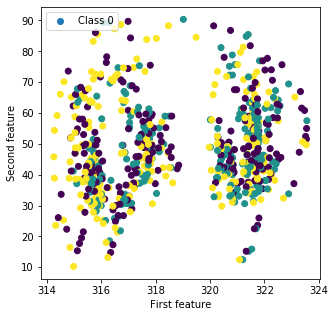

In [24]:
# plot
%matplotlib inline
plt.figure(figsize=(5, 5))
plt.scatter(X2D_arr[:, 0], X2D_arr[:, 1], c=y_arr)
plt.legend(["Class 0","Class 1","Class 1"], loc=2)
plt.xlabel("First feature")
plt.ylabel("Second feature")
print("X2D.shape:", X2D_arr.shape)

Now we select our two other features, ADX and Corr and print them (to make sure all is ok) and same for our y values.

In [25]:
X2D = X[['ADX','Corr']]
print("Our selected features: \n", X2D.head(1))
X2D_arr=X2D.values
print("Our X2D, first three rows: \n", X2D_arr[0:3,:])
y_arr=y.values
print("Our y values, first six rows: ", y_arr[0:6])

Our selected features: 
           ADX      Corr
20  13.793519  0.816229
Our X2D, first three rows: 
 [[13.79351895  0.81622948]
 [15.56313071  0.87181248]
 [17.58170343  0.91928604]]
Our y values, first six rows:  [-1 -1  1  1 -1  0]


Now we plot:

X2D.shape: (729, 2)


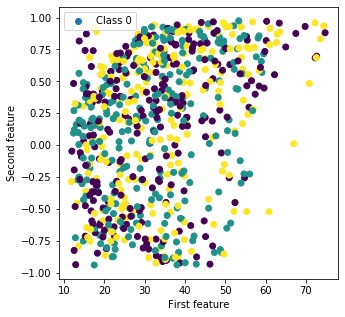

In [26]:
# plot
%matplotlib inline
plt.figure(figsize=(5, 5))
plt.scatter(X2D_arr[:, 0], X2D_arr[:, 1], c=y_arr)
plt.legend(["Class 0","Class 1","Class 1"], loc=2)
plt.xlabel("First feature")
plt.ylabel("Second feature")
print("X2D.shape:", X2D_arr.shape)

Again we choose two features:

In [27]:
X2D = X[['SAR','ADX']]
print("Our selected features: \n", X2D.head(1))
X2D_arr=X2D.values
print("Our X2D, first three rows: \n", X2D_arr[0:3,:])
y_arr=y.values
print("Our y values, first six rows: ", y_arr[0:6])

Our selected features: 
          SAR        ADX
20  319.1844  13.793519
Our X2D, first three rows: 
 [[319.1844      13.79351895]
 [318.91752     15.56313071]
 [318.654016    17.58170343]]
Our y values, first six rows:  [-1 -1  1  1 -1  0]


Again we plot:

X2D.shape: (729, 2)


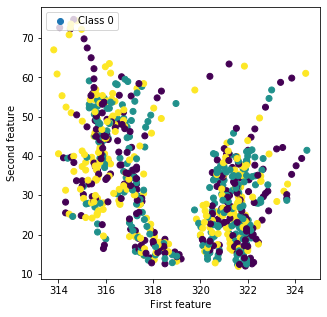

In [28]:
# plot
%matplotlib inline
plt.figure(figsize=(5, 5))
plt.scatter(X2D_arr[:, 0], X2D_arr[:, 1], c=y_arr)
plt.legend(["Class 0","Class 1","Class 1"], loc=2)
plt.xlabel("First feature")
plt.ylabel("Second feature")
print("X2D.shape:", X2D_arr.shape)

## FINDING BEST PARAMETERS

### Pipeline and Functions

As the very first step to finding the best hyper parameters among C, Gamma and Kernel, we will first create a pipeline of functions which are required to run in a certain order on the training data. 

The ‘steps’ contains references to functions that would be applied on the data when called through a pipeline function. In this case, we will scale the data first and then fit it to the SVC function. This is done to avoid effect of the individual weights of the features.


In [29]:
steps = [
         		('scaler',StandardScaler()),
        		('svc',SVC())
              ]
pipeline =Pipeline(steps)

In [30]:
tscv = TimeSeriesSplit(n_splits=7)
tscv_fw = fwTimeSeriesSplit(n_splits=7)

### Hyper-Parameters

The Hyper parameters are iterated over to arrive at the best possible combination for the given training data. These test values can be changed as per your choice. Here, we have chosen 4 test values for ‘c_gs’ and 3 test values for ‘g_gs’.  Similarly for random search we have included a range of parameter values.

In [31]:
#for grid search
c_gs =[10,100,1000,10000]
g_gs = [1e-2,1e-1,1e0] 

#for random search
c_rs = np.linspace(10, 10000, num=40, endpoint=True)
g_rs = np.linspace(1e-2, 1e0, num=30, endpoint=True)

The RBF is used as a singular entry in the kernel parameters, since we already know we want to use this kernel. But you can go ahead and  try other kernel functions, such as linear, poly and sigmoid. Do remember: A higher number of parameters would result in a longer time for the code to run. 

In [32]:
#set of parameters for grid search
parameters_gs = {
              		'svc__C':c_gs,
              		'svc__gamma':g_gs,
              		'svc__kernel': ['rbf', 'poly']
             	           }
#set of parameters for random search
parameters_rs = {
              		'svc__C':c_rs,
              		'svc__gamma':g_rs,
              		'svc__kernel': ['rbf', 'poly']
             	           }

In [33]:
Df.groupby("Signal").count() #shows -1, 0 and 1 occur in roughly equal numbers

,Time,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,...,Ret,return1,return2,return3,return4,return5,return6,return7,return8,return9
Signal,,,,,,,,,,,,,,,,,,,,,
-1,235,235,235,235,235,235,235,235,235,235,...,235,235,235,235,235,235,235,235,235,235
0,252,252,252,252,252,252,252,252,252,252,...,252,252,252,252,252,252,252,252,252,252
1,242,242,242,242,242,242,242,242,242,242,...,242,242,242,242,242,242,242,242,242,242


## GRID OR RANDOMIZED SEARCH OPTIONS

Next, we create a parameter optimizing function with a cross validation value of cv=7. This value can be anything more than or equal to 3. Alternatively cv=tscv or cv=tscv_fw. The concept of cross validation is used to arrive at the scores of different random combinations of the hyper parameters.
These scores would be used to find the best parameters and create a newly optimized Support vector classifier.

In [34]:
from sklearn.metrics import SCORERS
#sorted(SCORERS.keys()) #to get available scorers

In [35]:
#cvo = GridSearchCV(pipeline, parameters_gs,cv=7, scoring=None)
#cvo = RandomizedSearchCV(pipeline, parameters_rs,cv=7, scoring=None, n_iter=50, random_state=None)
cvo = RandomizedSearchCV(pipeline, parameters_rs,cv=tscv, scoring=None, n_iter= 50, random_state=70) #7 
#cvo = RandomizedSearchCV(pipeline, parameters_rs,cv=tscv_fw, scoring=None, n_iter=50, random_state=None)

### Training on and fetching the best parameters
             
Next, we fit the train data to the 'randomized search cross validation' function to obtain the best hyper parameters. The best parameters can be obtained using the best_params function.

In [36]:
cvo.fit(X.iloc[:split],y.iloc[:split])
best_C = cvo.best_params_['svc__C']
best_kernel =cvo.best_params_['svc__kernel']
best_gamma=cvo.best_params_['svc__gamma']

## CREATING THE SEARCH VECTOR MODEL

### Creating the new SVC

In this line of code we instantiate a new support vector classifier function with the best hyper parameters. 

In [37]:
cls = SVC(C =best_C,kernel=best_kernel, gamma=best_gamma)

### Training and Predicting

As done previously for finding best hyper parameters, we will first scale the data before we fit it to the classifier to train on. To do this, we fist instantiate a Standard Scaler function.

In [38]:
ss1= StandardScaler()

We use the scaled training data to train the classifier algorithm.

In [39]:
cls.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])

SVC(C=7694.615384615384, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

After the previous step, our prediction model is ready! 

Next, we use the test data to make predictions and save the value of output ‘y’ in a list called 'y_predict'. This list will have the predicted values of ‘Signal’ for the test data.  

In [40]:
y_predict =cls.predict(ss1.transform(X.iloc[split:]))

In [41]:
y_predict

array([ 0,  0,  1,  1,  1, -1, -1,  0,  0, -1,  0,  0, -1,  1,  0, -1,  1,
        0, -1,  0,  0,  0, -1,  1, -1,  1,  0, -1,  0, -1, -1, -1,  1, -1,
        1,  0,  0,  1,  0, -1,  1, -1, -1,  0,  0,  1, -1,  0, -1,  0,  1,
       -1,  1,  1,  1,  0, -1,  0, -1,  1, -1,  1, -1,  1,  1, -1,  0, -1,
       -1,  1,  0,  0, -1, -1,  1,  0,  0,  1, -1,  0,  0,  1, -1,  0,  0,
        0, -1,  1,  0,  1,  0,  1, -1, -1, -1,  0, -1,  0,  0,  0,  0, -1,
       -1, -1, -1, -1, -1,  0, -1,  0, -1,  0,  0, -1,  0, -1,  0, -1,  1,
       -1, -1,  1,  1, -1,  1, -1, -1, -1,  0], dtype=int64)

Now we will create a new column 'Pred_Signal' in ‘Df’ to save all the predictions for both train data and test data.

In [42]:
Df['Pred_Signal']=0

To save predicted 'y' values for test data, we can simply assign 'y_predict' to 'Pred_Signal' using correct indexing specified by .iloc function.
To save predicted 'y' values for train data, we make predictions for train data and save it similarly.

In [43]:
Df.iloc[:split,Df.columns.get_loc('Pred_Signal')]\
       =pd.Series(cls.predict(ss1.transform(X.iloc[:split])).tolist())
Df.iloc[split:,Df.columns.get_loc('Pred_Signal')]=y_predict

Since, the algorithm was trained on the train data, it’s accuracy of prediction is expected to be better on this train data compared to the test data. You can print these two seperately to check the accuracies. 

# EVALUATING THE SIGNAL PART OF THE MODEL WITH A CLASSIFICATION REPORT AND CONFUSION MATRIX VS. DUMMY

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

Evaluation by a Dummy Classifier

              precision    recall  f1-score   support

          -1       0.26      0.42      0.32        31
           0       0.52      0.40      0.45        60
           1       0.21      0.18      0.20        38

    accuracy                           0.34       129
   macro avg       0.33      0.33      0.32       129
weighted avg       0.37      0.34      0.35       129



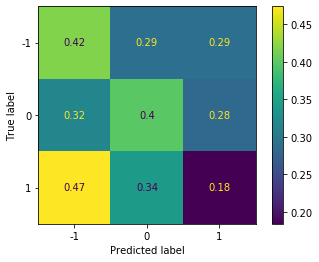

In [45]:
cls_d = DummyClassifier(strategy='uniform',random_state=1) #can substitute for some other strategy
cls_d.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])
y_predict_d =cls_d.predict(ss1.transform(X.iloc[split:]))

#Plot classification report onfusion matrix of dummy
print(classification_report(Df['Signal'].iloc[split:], y_predict_d))
#plot_confusion_matrix(cls_d,ss1.transform(X.iloc[split:]),Df['Signal'].iloc[split:])
plot_confusion_matrix(cls_d,ss1.transform(X.iloc[split:]),Df['Signal'].iloc[split:], normalize='true')

Next we se the classification report and confusion matrix of our classifier. Thay should be better than those of the dummy classifier above:

              precision    recall  f1-score   support

          -1       0.35      0.58      0.43        31
           0       0.59      0.45      0.51        60
           1       0.45      0.37      0.41        38

    accuracy                           0.46       129
   macro avg       0.46      0.47      0.45       129
weighted avg       0.49      0.46      0.46       129



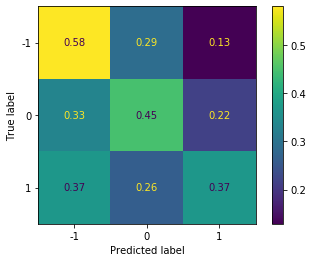

In [46]:
#ploy classification report and confusion matrix of our classifier
print(classification_report(Df['Signal'].iloc[split:], y_predict))
#plot_confusion_matrix(cls,ss1.transform(X.iloc[split:]),Df['Signal'].iloc[split:])
plot_confusion_matrix(cls,ss1.transform(X.iloc[split:]),Df['Signal'].iloc[split:], normalize='true')

## USING THE MODEL FOR TRADING STRATEGY 

### Trading Strategy 
        
Our trading strategy is simply to buy/sell/do-nothing at that period for which the Signal is generated by the algorithm. The strategy assumes that you always get a fill at the "Open" prices. 

### Analysing the Performance

Recall, we had calculated and saved returns on 'Open' prices in 'Ret'. We will create a column named Ret1 to store the strategy’s returns based on the Signal. ‘Cu_Ret1’ is initialized to hold cumulative returns of our strategy.  

In [47]:
Df['Ret1']=Df['Ret']*Df['Pred_Signal'] 
Df['Cu_Ret1']=0.

Please note that here we are using only the test data to compare the performance of the strategy. You can pass the entire 'Ret1' column and check the performance on both the test and train data if you wish to.

In [48]:
Df['Cu_Ret1']=np.cumsum(Df['Ret1'].iloc[split:])

Now, we will create a column named 'Cu_Ret' to store the cumulative market’s returns for the test data.

In [49]:
Df['Cu_Ret']=0.
Df['Cu_Ret']=np.cumsum(Df['Ret'].iloc[split:])

Next, we will calculate the standard deviation of the cumulative strategy returns, and use it to further to calculate the Sharpe ratio, which is used as a measure for the strategy's performance.

In [50]:
Std =np.std(Df['Cu_Ret1'])
Sharpe = (Df['Cu_Ret1'].iloc[-1]-Df['Cu_Ret'].iloc[-1])/Std #will not annualize this because the data is intraday data
print('Sharpe Ratio:',Sharpe)

Sharpe Ratio: 2.4991510767921765


### Plot the result

Now you can plot the results to visualize the performance.


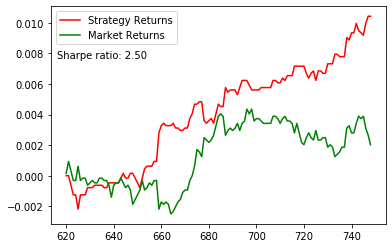

In [51]:
plt.plot(Df['Cu_Ret1'],color='r',label='Strategy Returns')
plt.plot(Df['Cu_Ret'],color='g',label='Market Returns')
plt.figtext(0.14,0.7,s='Sharpe ratio: %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()

In [52]:
#Having run the code a number of times with fixed window and with growing window TimeSeriesSplit, that is:
#tscv = TimeSeriesSplit(n_splits=7)
#tscv = fwTimeSeriesSplit(n_splits=7)
#The maximum values are:
#Sharpe Ratio: --- with growing window (maximum)
#Sharpe Ratio: --- with fixed window (maximum)

To find out if the trading results (the profits) are by chance, it is necessary to run White's Reality Check.

In [53]:
import WhiteRealityCheckFor1 
import detrendPrice 
#Detrend prices before calculating detrended returns
Df['DetOpen'] = detrendPrice.detrendPrice(Df['Open']).values 
#these are the detrended returns to be fed to White's Reality Check
Df['DetRet']=np.log(Df['DetOpen'].shift(-1)/Df['DetOpen'])
Df['DetStrategy']=Df['DetRet']*Df['Pred_Signal'] 
WhiteRealityCheckFor1.bootstrap(Df['DetStrategy'].iloc[split:])
print("done!")

    average return 0.006357
     [-0.00474277  0.00503302]
    Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
    p_value: 0.005800000000000027
done!


INTERPRETATION OF CLASSIFICATION REPORT FOR CLASSIFIER PREDICTING A BINARY LABEL TARGET

    Balanced class: In this situation, the F1 score can effectively be ignored, the mis-classification rate is key.
    Unbalanced class, but both classes are important: If the class distribution is highly skewed (such as 80:20 or 90:10), then a classifier can get a low mis-classification rate simply by choosing the majority class. In such a situation, choose the classifier that gets high F1 scores on both classes, as well as low mis-classification rate. A classifier that gets low F1-scores should be overlooked.
    Unbalanced class, but one class if more important that the other. For e.g. in Fraud detection, it is more important to correctly label an instance as fraudulent, as opposed to labeling the non-fraudulent one. In this case, pick the classifier that has a good F1 score only on the important class. 

Always: compare the results with those of a dummy classifier


# Answer to Questions:

## Question 1:
Regarding, 

cvo = RandomizedSearchCV(pipeline, parameters_rs,cv=tscv, scoring=None, n_iter= 50, random_state=7) 

,specifically, parameter parameters_rs, in particular the line,

parameters_rs = {
              		'svc__C':c_rs,
              		'svc__gamma':g_rs,
              		'svc__kernel': ['rbf', 'poly']
             	           }
                           
Does this line need to be modified to 

parameters_rs = {
              		'svc__C':c_rs,
              		'svc__gamma':g_rs,
              		'svc__kernel': ['rbf', 'poly', 'linear']
             	           }

Why or why not? 

## Answer to Q1:

No. It's not needed to add the linear kernel. 
According to data visualization, it is clear that the dataset is not linearly separable. 
Thus it requires a non-linear kernel such as rbf or polynommial.


## Question 2 
Regarding, 

cvo = RandomizedSearchCV(pipeline, parameters_rs,cv=tscv, scoring=None, n_iter= 50, random_state=7) 

,specifically, scoring = None, What is the actual value of this parameter? Does it need to be changed? Why or why not?

## Answer to Q2:

When scoring = None, the estimator’s scoring method is used. In this case it is SVC's default scoring.
SVC's scoring return the mean accuracy on the given test data and labels, which is used here. 
Different scoring measures can be used here, for example, "precision" or "roc_auc", or multiple metrics can be evaluated at the same time by changing this value to a list of strings.

## Question 3

Regarding,

cvo = RandomizedSearchCV(pipeline, parameters_rs,cv=tscv, scoring=None, n_iter= 50, random_state=7) 

,specifically, cv=tscv, Does this parameter influence the results a lot if you change it to cv=7 or cv=tscv_fw or cv=tscv
In theory, which is the best setting (assuming scoring function is unchanged).



In [8]:
import ClassificationSVM_SPY
n=10
for cv_test in [7,"tscv","tscv_fw"]:
    print("cv = ", cv_test)
    if cv_test == 7:
        cv_test= "CV7"
    Sharpe, WhiteRealityCheck_p_value = ClassificationSVM_SPY.SVC_model(n,cv_model=cv_test,random_state_model=7)
    print("Sharpe, ", Sharpe, "; WhiteRealityCheck p-value, ", WhiteRealityCheck_p_value)
    print()

cv =  7
    SVC Classifier, accuracy= 0.434
Sharpe,  3.326813591969702 ; WhiteRealityCheck p-value,  0.02739999999999998

cv =  tscv
    SVC Classifier, accuracy= 0.419
Sharpe,  3.1866759927987247 ; WhiteRealityCheck p-value,  0.041000000000000036

cv =  tscv_fw
    SVC Classifier, accuracy= 0.364
Sharpe,  3.033072850221856 ; WhiteRealityCheck p-value,  0.03639999999999999



## Answer to Q3:

Models are training based on the three different ways of splitting the data, cv=7, tscv and tscv_fw. Sharpe ratios are quite similar and WhiteRealityCheck p-value is low which implies strong statistical significance. The answer is YES, using different splitting methods will slightly change the result.

tscv_fw and tscv are both timeseries split. tscv_fw has fixed window of training set. It does not contain any overlapping folds at all! On the other hand, tscv has a growing window. The growing window split overlap at the beginning so the dataset in the earlier series
are given more significance. This makes the difference in the final result.

When cv inputs are integer/None, and the estimator is a classifier, StratifiedKFold is used, which ensures the rearranging of data in each fold is a good representative of the whole. This will not retain the order of the time series data. It actually ruins the trend of the timeseries data, but sometimes would train a model with better predictions.

In theory, a normal K-fold cross-validation procedure is sufficient for machine learning models, with the assumption that the residuals of the model are uncorrelated. Theoretical proof was published in (Bergmeira, C. 2017 et. al). The author also stated that in most cases, cross-validation can effectively control overfitting. Even if the lag structure is not perfect, a normal K-fold cross-validation without any modifications can be used as a empirical solution. Therefore, we actually observe a better result when using cv=7 (split method without modifying for time-series). 


## Question 4:
Regarding,

cvo = RandomizedSearchCV(pipeline, parameters_rs,cv=tscv, scoring=None, n_iter= 50, random_state=7) 

,specifically, cv=tscv_fw, regardless of the result of this notebook what advantage (and what disadvantage) does 
the TimeSeriesSplit object with fixed window provide over the TimeSeriesSplit object with growing window

## Answer to Q4:

The advantage of the fixed window is that a new set of training data and validation data is used for
every training iteration. For growing window, the second time you train, you will include the dataset from
the first training set, and the third time you train, you will have included the first training dataset three
times, and the second training set two times. So the issue with growing window is the earlier dataset would
have much more weighs contributed to the model since all the training set overlap at the beginning of
the series. Whereas in the fixed window split, each data point contributes equally to the model output.

## Question 5:
Regarding classification report and confusion matrix of our SVC classifier compared to the DUMMY,specifically,

cls_d = DummyClassifier(strategy='uniform')

why is the strategy set to uniform and not some other (see)
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html


## Answer to Q5:

Text(0.5, 1.0, 'Histogram Showing the Size of Each Signal Class')

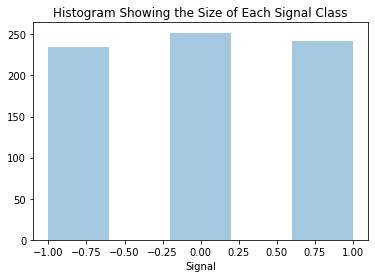

In [54]:
# Plot a histogram to show the size of each class
import seaborn as sns
sns.distplot(y.iloc[:], kde=False)
plt.title("Histogram Showing the Size of Each Signal Class")

DummyStrategy="uniform"
               precision    recall  f1-score   support

          -1       0.19      0.26      0.22        31
           0       0.57      0.48      0.52        60
           1       0.31      0.29      0.30        38

    accuracy                           0.37       129
   macro avg       0.36      0.34      0.35       129
weighted avg       0.40      0.37      0.38       129

DummyStrategy="constant"
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00        31
           0       0.00      0.00      0.00        60
           1       0.29      1.00      0.46        38

    accuracy                           0.29       129
   macro avg       0.10      0.33      0.15       129
weighted avg       0.09      0.29      0.13       129

DummyStrategy="most_frequent"
               precision    recall  f1-score   support

          -1       0.24      1.00      0.39        31
           0       0.00      0.00      0.00    

C:\Anaconda2\envs\aps1052\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda2\envs\aps1052\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Our Classifier')

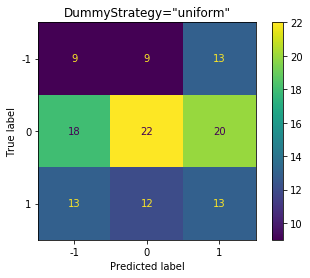

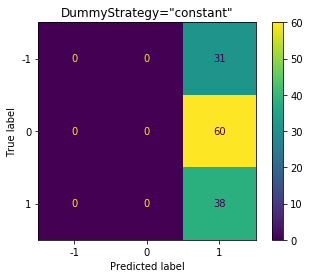

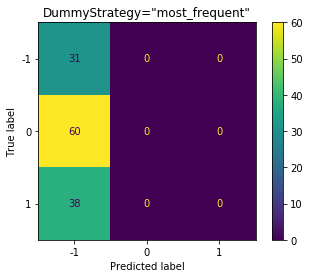

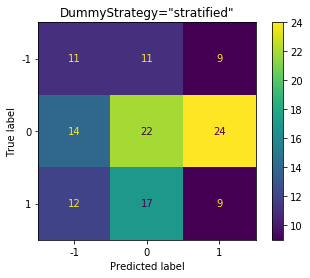

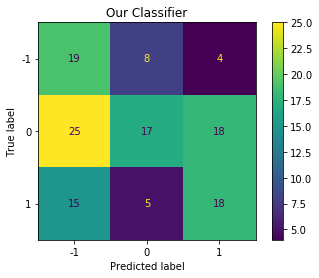

In [55]:
# Compare different Dummy Classifier Strategies

cvo = RandomizedSearchCV(pipeline, parameters_rs,cv=tscv, scoring=None, n_iter= 50, random_state=7)
cvo.fit(X.iloc[:split],y.iloc[:split])
best_C = cvo.best_params_['svc__C']
best_kernel =cvo.best_params_['svc__kernel']
best_gamma=cvo.best_params_['svc__gamma']
cls = SVC(C =best_C,kernel=best_kernel, gamma=best_gamma)
ss1= StandardScaler()

cls.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])
y_predict =cls.predict(ss1.transform(X.iloc[split:]))
Df['Pred_Signal']=0
Df.iloc[:split,Df.columns.get_loc('Pred_Signal')]\
       =pd.Series(cls.predict(ss1.transform(X.iloc[:split])).tolist())
Df.iloc[split:,Df.columns.get_loc('Pred_Signal')]=y_predict

cls_d = DummyClassifier(strategy='uniform') #can substitute for some other strategy
cls_d.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])
y_predict_d =cls_d.predict(ss1.transform(X.iloc[split:]))
print("DummyStrategy=\"uniform\"\n",classification_report(Df['Signal'].iloc[split:], y_predict_d))
plot_confusion_matrix(cls_d,ss1.transform(X.iloc[split:]),Df['Signal'].iloc[split:], normalize=None)
plt.title("DummyStrategy=\"uniform\"")

cls_d = DummyClassifier(strategy='constant',constant=1) #can substitute for some other strategy
cls_d.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])
y_predict_d =cls_d.predict(ss1.transform(X.iloc[split:]))
print("DummyStrategy=\"constant\"\n",classification_report(Df['Signal'].iloc[split:], y_predict_d))
plot_confusion_matrix(cls_d,ss1.transform(X.iloc[split:]),Df['Signal'].iloc[split:], normalize=None)
plt.title("DummyStrategy=\"constant\"")

cls_d = DummyClassifier(strategy='most_frequent') #can substitute for some other strategy
cls_d.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])
y_predict_d =cls_d.predict(ss1.transform(X.iloc[split:]))
print("DummyStrategy=\"most_frequent\"\n",classification_report(Df['Signal'].iloc[split:], y_predict_d))
plot_confusion_matrix(cls_d,ss1.transform(X.iloc[split:]),Df['Signal'].iloc[split:], normalize=None)
plt.title("DummyStrategy=\"most_frequent\"")

cls_d = DummyClassifier(strategy='stratified') #can substitute for some other strategy
cls_d.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])
y_predict_d =cls_d.predict(ss1.transform(X.iloc[split:]))
print("DummyStrategy=\"stratified\"\n",classification_report(Df['Signal'].iloc[split:], y_predict_d))
plot_confusion_matrix(cls_d,ss1.transform(X.iloc[split:]),Df['Signal'].iloc[split:], normalize=None)
plt.title("DummyStrategy=\"stratified\"")


print("Our Classifier\n",classification_report(Df['Signal'].iloc[split:], y_predict))
plot_confusion_matrix(cls,ss1.transform(X.iloc[split:]),Df['Signal'].iloc[split:], normalize=None)
plt.title("Our Classifier")

## Answer to Q5:(Continued)
A dummy classifier is used as a baseline of the model we trained. A comparison between the dummy classifier (which we used as a baseline) and the SVC model we trained allows us to concretely state the benefits of using this machine learning approach.

From the histogram that shows the size of the three signal classes (-1,0,1), we see the sizes are similar. Therefore, a dummy classifier that use a most_frequent strategy (or use a "constant" strategy with constant being equal to the most frequent class) won't raise the accuracy of the prediction and is not favourable in this multi-class classification problem here. 


A "stratified" dummy classifier strategy is to generate predictions by respecting the training set's class distribution, 
Since the sizes of three classes are very close to each other, using a "stratified" strategy and a "uniform" strategy are quite similar in this case. Since the class distribution of the training set and that of the test set are not necessarily similar, using a uniform strategy is more favourable here. 

Without computing a confusion matrix, we can expect that using a "uniform" strategy for the dummy classifier will allow us to get a fairly good baseline that can be compared against the SVC model we trained to show an improved performance we achieved. As a matter of fact, this can be seen from the classification report and confusion matrix made for each dummy classifier strategy.

## Question 6:
Regarding classification report and confusion matrix of our SVC classifier compared to the DUMMY, specifically,

the classification report table and confusion matrix plot

what are we comparing between our classifier and the DUMMY?

## Answer to Q6:

As discussed in Answer to Question 5, the dataset are fairly balanced as can be seen from the histogram (the size of each class is similar to each other). Therefore, the F1 score can be effectively ignored and the mis-classification rate is used for comparison between the classifiers here. Mis-classification rate is simply 1 - accuracy, the value of which can be obtained directly from the classification report printed in the output. In other words, we can simply compare the value of accuracy in the outputs. The accuracy of our classifier is 0.46 (random_state=70) which is apparently larger than that of the dummy classifier which ranges from 0.26 to 0.37 (using a "uniform" strategy is to randonly generating predictions based on a uniform distribution, therefore the value of accuracy varies across multiple runs).




## Question 7:
Regarding classification report and confusion matrix of our SVC classifier compared to the DUMMY, specifically,
the classification report table and confusion matrix plot.
Can you get the classifier to become better than the DUMMY (even slightly better)
by running the notebook many times. For this you need to change the random_state=7 in:

cvo = RandomizedSearchCV(pipeline, parameters_rs,cv=tscv, scoring=None, n_iter= 50, random_state=7) 

to some other number. (If you set it to random_state=None, random numbers will be used)
How much better?

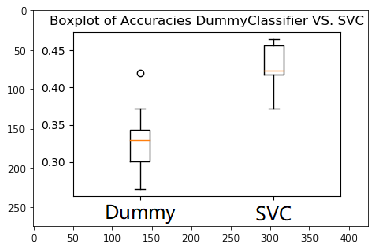

In [56]:
'''
SVC_Accuracy=[]
DummyC_Accuracy=[]
for rs1 in range(20):
    cvo = RandomizedSearchCV(pipeline, parameters_rs,cv=tscv, scoring=None, n_iter= 50, random_state=rs1)
    cvo.fit(X.iloc[:split],y.iloc[:split])
    best_C = cvo.best_params_['svc__C']
    best_kernel =cvo.best_params_['svc__kernel']
    best_gamma=cvo.best_params_['svc__gamma']
    cls = SVC(C =best_C,kernel=best_kernel, gamma=best_gamma)
    ss1= StandardScaler()

    cls.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])
    y_predict =cls.predict(ss1.transform(X.iloc[split:]))
    Df['Pred_Signal']=0
    Df.iloc[:split,Df.columns.get_loc('Pred_Signal')]\
           =pd.Series(cls.predict(ss1.transform(X.iloc[:split])).tolist())
    Df.iloc[split:,Df.columns.get_loc('Pred_Signal')]=y_predict

    cls_d = DummyClassifier(strategy='uniform',random_state=rs1) #can substitute for some other strategy
    cls_d.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])
    y_predict_d =cls_d.predict(ss1.transform(X.iloc[split:]))
    print("random_state=", rs1,":")
    print("DummyStrategy=\"uniform\", accuracy=",round(classification_report(Df['Signal'].iloc[split:], y_predict_d,output_dict=True)["accuracy"],3))
    print("Our Classifier, accuracy=",round(classification_report(Df['Signal'].iloc[split:], y_predict,output_dict=True)["accuracy"],3))
    DummyC_Accuracy.append(round(classification_report(Df['Signal'].iloc[split:], y_predict_d,output_dict=True)["accuracy"],3))
    SVC_Accuracy.append(round(classification_report(Df['Signal'].iloc[split:], y_predict,output_dict=True)["accuracy"],3))
    
fig_z, ax_z = plt.subplots()
ax_z.set_title('Boxplot of Accuracies DummyClassifier VS. SVC')
ax_z.boxplot([DummyC_Accuracy,SVC_Accuracy])
'''
# Runtime is a little bit too long, the result figure has been saved and showed directly here
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt   
img = mpimg.imread('Boxplot_Accuracies2.png')  
plt.imshow(img) 

## Answer to Q7:(Continued)
The value of random_state are being set to 20 different values (0-19). Using the 20 values of random_state, we obtain a list of accuracies of the svc classifier model. Although in some cases, our classifier model is not more than slightly better than the dummy classifier (i.e., random_state=16), in most cases, we see a significant difference between the accuracy and the SVC classifier apparently has an improved performance of predicting the signals.



## Question 8:
Regarding Trading results, specifically,

plt.plot(Df['Cu_Ret1'],color='r',label='Strategy Returns')

plt.plot(Df['Cu_Ret'],color='g',label='Market Returns')

Wherever the classifier better than the DUMMY (even slightly better) are the trading results better too?
Look at: 

The plot of the cummulative returns.

The p_value (which should be < .05 to be siginificant) of the White Reality Check.

(low p_value means the profits are not by chance, not due to any the trend in the data)


Dummy Classifier Sharpe Ratio: -3.2397351205328437
SVC Strategy Sharpe Ratio: 4.379471139735849


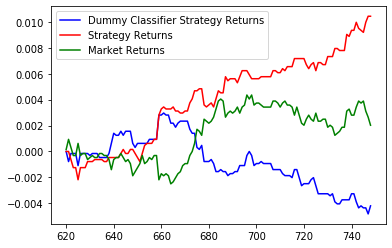

White's Reality Check for SVC classifier (our model) are shown as follows,
    average return 0.004740
     [-0.00540428  0.00523342]
    Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
    p_value: 0.03700000000000003

White's Reality Check for Dummy Classifier are shown as follows,
    average return -0.002282
     [-0.0048677   0.00497964]
    Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
    p_value: 0.8154


0.8154

In [57]:
Df['Pred_Signal']=0
Df.iloc[:split,Df.columns.get_loc('Pred_Signal')]\
       =pd.Series(cls.predict(ss1.transform(X.iloc[:split])).tolist())
Df.iloc[split:,Df.columns.get_loc('Pred_Signal')]=y_predict

cls_d = DummyClassifier(strategy='uniform',random_state=1) #can substitute for some other strategy
cls_d.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])
y_predict_d =cls_d.predict(ss1.transform(X.iloc[split:]))
Df['Pred_Signal_d']=0
Df.iloc[:split,Df.columns.get_loc('Pred_Signal_d')]\
       =pd.Series(cls_d.predict(ss1.transform(X.iloc[:split])).tolist())
Df.iloc[split:,Df.columns.get_loc('Pred_Signal_d')]=y_predict_d

Df['Ret1_d']=Df['Ret']*Df['Pred_Signal_d'] 
Df['Cu_Ret1_d']=0.
Df['Cu_Ret1_d']=np.cumsum(Df['Ret1_d'].iloc[split:])
Df['Cu_Ret']=0.
Df['Cu_Ret']=np.cumsum(Df['Ret'].iloc[split:])
Std =np.std(Df['Cu_Ret1_d'])
Sharpe = (Df['Cu_Ret1_d'].iloc[-1]-Df['Cu_Ret'].iloc[-1])/Std #will not annualize this because the data is intraday data
print('Dummy Classifier Sharpe Ratio:',Sharpe)
Sharpe = (Df['Cu_Ret1'].iloc[-1]-Df['Cu_Ret'].iloc[-1])/Std #will not annualize this because the data is intraday data
print('SVC Strategy Sharpe Ratio:',Sharpe)
plt.plot(Df['Cu_Ret1_d'],color='b',label='Dummy Classifier Strategy Returns')
plt.plot(Df['Cu_Ret1'],color='r',label='Strategy Returns')
plt.plot(Df['Cu_Ret'],color='g',label='Market Returns')
#plt.figtext(0.14,0.7,s='Sharpe ratio: %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()
#Detrend prices before calculating detrended returns
Df['DetOpen'] = detrendPrice.detrendPrice(Df['Open']).values 
#these are the detrended returns to be fed to White's Reality Check
print("White's Reality Check for SVC classifier (our model) are shown as follows,")
Df['DetRet']=np.log(Df['DetOpen'].shift(-1)/Df['DetOpen'])
Df['DetStrategy']=Df['DetRet']*Df['Pred_Signal'] 
WhiteRealityCheckFor1.bootstrap(Df['DetStrategy'].iloc[split:])
print()
print("White's Reality Check for Dummy Classifier are shown as follows,")
Df['DetStrategy_d']=Df['DetRet']*Df['Pred_Signal_d'] 
WhiteRealityCheckFor1.bootstrap(Df['DetStrategy_d'].iloc[split:])

## Answer to Q8:(Continued)
As shown by the graph of the returns, the trading result of the SVC classifier is better than the baseline (that of the dummy classifier). The p-value being smaller than 0.05 shows the statistical significance of rejecting the null hypothesis which claims that the population distribution of rule returns has an expected value of zero or less. This implies the strategy based on SVC classifier actually brings profit not by chance or due to any trend in the data. On the other hand, the dummy classifier brings a significant loss. The large p-value also implies the same conclusion (the population distribution of rule returns has an expected value of zero or less).


## Question 9:

How the length of the lookback window n= 10 (originally n=5) affect the result?

Change the value to n=2, to n=5, to n=10, to n=50

What seems to be the best window setting (you may have to run the notebook a number of times in each window setting by changing to random_state=None)?



In [58]:
import ClassificationSVM_SPY
'''
for n in [50,10]:
    print("For window n = " , n , ":")
    for i in range(10):
        print("Run #" , i+1 )
        Sharpe, WhiteRealityCheck_p_value = ClassificationSVM_SPY.SVC_model(n,cv_model="tscv")
        print("Sharpe, ", Sharpe, "; WhiteRealityCheck p-value, ", WhiteRealityCheck_p_value)
        print()
        '''

'\nfor n in [50,10]:\n    print("For window n = " , n , ":")\n    for i in range(10):\n        print("Run #" , i+1 )\n        Sharpe, WhiteRealityCheck_p_value = ClassificationSVM_SPY.SVC_model(n)\n        print("Sharpe, ", Sharpe, "; WhiteRealityCheck p-value, ", WhiteRealityCheck_p_value)\n        print()\n        '

In [59]:
'''
n=5
print("For window n = " , n , ":")
i=0
print("Run #" , i+1 )
Sharpe, WhiteRealityCheck_p_value = ClassificationSVM_SPY.SVC_model(n,cv_model="tscv")
print("Sharpe, ", Sharpe, "; WhiteRealityCheck p-value, ", WhiteRealityCheck_p_value)
print()
'''

'\nn=5\nprint("For window n = " , n , ":")\ni=0\nprint("Run #" , i+1 )\nSharpe, WhiteRealityCheck_p_value = ClassificationSVM_SPY.SVC_model(n)\nprint("Sharpe, ", Sharpe, "; WhiteRealityCheck p-value, ", WhiteRealityCheck_p_value)\nprint()\n'

In [ ]:
'''
n=2
print("For window n = " , n , ":")
i=0
print("Run #" , i+1 )
Sharpe, WhiteRealityCheck_p_value = ClassificationSVM_SPY.SVC_model(n,cv_model="tscv")
print("Sharpe, ", Sharpe, "; WhiteRealityCheck p-value, ", WhiteRealityCheck_p_value)
print()
'''

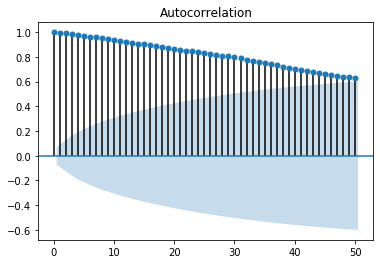

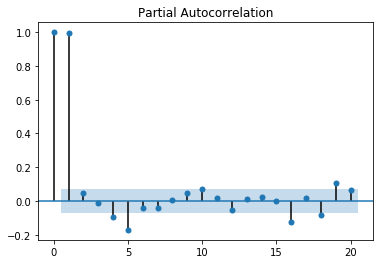

In [64]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(Df['Close'], lags=50)
plot_pacf(Df['Close'], lags=20)
plt.show()

In [2]:
import ClassificationSVM_SPY
for n in [10]:
    print("For window n = " , n , ":")
    for i in range(1):
        print("Run #" , i+1 )
        Sharpe, WhiteRealityCheck_p_value = ClassificationSVM_SPY.SVC_model(n,cv_model="tscv")
        print("Sharpe, ", Sharpe, "; WhiteRealityCheck p-value, ", WhiteRealityCheck_p_value)
        print()

For window n =  10 :
Run # 1
    SVC Classifier, accuracy= 0.434
Sharpe,  2.6305972862669496 ; WhiteRealityCheck p-value,  0.006000000000000005



## Answer to Q9:(Continued)
The length of the lookback window largely affect the result. The window setting equals to 10 seems to be the best one, based on the Sharpe ratio as well as WhiteRealityCheck p-value output by the above code. This result agrees with the PACF plot above, which shows lag 10 has a strong partial autocorrelation.

## Question 10:
Assuming we want a trading system to get the big moves right (at least) not giving
too much importance to the small moves, what is the problem with our SVC classifier?
What can one do to solve this?

## Answer to Q10:
The metric currently used pays great attention on predicting the small changes rather than predicting the big changes. In order to get the big moves right, we want to model the big ups and downs more accurately but not the small ones. Therefore, we need to think of a way for the model to do that.
Another problem of the current metric is that it only reports the accuracy of the direction, rather than the magnitude, which is also very important when assessing the model. We can also try metric scoring that can reflect the magnitude, for example, instead of modeling a signal classifier, we can use a regression tree to take into account the magnitude directly. Another potential solution could be using an ensemble of models (i.e., Bayesian Ensemble Methods). Bayesian model averaging (BMA) is generally considered the standard model for creating ensembles of learners using Bayesian methods. Bayesian Model Combination (BMC) which is based on BMA, helps to select the best combination of models used for ensembles of learners. The potential learners we can use in an ensemble that models the magnitude include random forest, regression tree, support vector regressor, kernel ridge regressor, K-NN regressor, gaussian process regressor, gradient boosting regressor, etc. In this way, big ups and downs can be modelled by those learners. Ensembles can then be created using BMC methods to allow the model to improve its ability of predicting “big changes”.

